To see how the initial simulation was run and the initial RDF calcaulted see /Setup/Na-Na_Setup.ipynb

## Importing Libraries

environment.yml contains environment with packages

Also requires:

MagiC-3 and MagicTools (http://www.fos.su.se/~sasha/magic/)

LAMMPS (9 Oct 2020 version was used)

LAMMPS MISC package for .xtc dump files

In [ ]:
os.system('conda env create -n myenv -f environment.yml')
#use conda to load most necessary Python packages 
#MagicTools may need to be downloaded and installed separately

In [1]:
import MagicTools as mt

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import os

import string

import itertools as it

from scipy.signal import savgol_filter

import random
random.seed(1)

In [ ]:
#os.system('conda env export > environment.yml')

#recording packages used
#does not need to be run unless packages required for notebook are changed

## Running the LAMMPS simulations

It is necessary to run a large number of LAMMPS simulations to generate the training data for the network

LAMMPS used: 9 Oct 2020 version

MISC package for .xtc dump files

In [4]:
input_rdf = mt.ReadRDF('Setup/NaNa.rdf', quiet= True) 
#This is the CG RDF file from the initial atomistic simulation

Min = 0  
Max = input_rdf.DFs[0].Max 
#range of r for potentials

In [5]:
forbid = input_rdf.DFs[0].x[0] 
#this is the starting point for any potential, below this potential should be large
#this should be altered so that if the RDF contains very low values at the start (say <= 0.1), these likely still are
#part of the forbidden region and should be treated as such


stepsize = input_rdf.DFs[0].x[1] - input_rdf.DFs[0].x[0] 
#the distance between each point in the potential 
rvalues = np.arange(Min + stepsize/2, Max + stepsize/2, stepsize) 
#an array containg the r values

for i in range(len(rvalues)):
    rvalues[i] = round(rvalues[i], 6) 
    #rounding the rvalues to prevent floating point errors
    
NPoints = len(rvalues) 
#the neumber of points in each full RDF/potential

Creating the trial potentials for the simulations

In [4]:
def create_potential(N, forbidden): 
    #this function creates a random potential of N points
    #forbidden region size forbid (in aangstroms)
    #the potential is smoothed using a savgol filter
    
    pot = np.zeros(N) 
    #the array which will hold the potential
    
    rs = list(rvalues)
    forbid = rs.index(forbidden) 
    #determines the index of the forbidden region (where in the list of rvalues it appears)
    
    for i in range(forbid):
        pot[i] = 75000 - 50*i 
    #within the forbidden region the potential is simply a very large potential, decreasing linearly

    non_forbid = np.zeros(N - forbid) 
    #non_forbid contains the potenital outside the forbidden region
    non_forbid[0] = random.gauss(0, 2.5) 
    #The value of the potential just outside the forbidden region is 
    #taken from a Gaussian centred on zero with standard deviation 2.5
    
    i = 1
    
    while i < len(non_forbid):
        non_forbid[i] = non_forbid[i - 1] + random.random() * random.gauss(0, .5)
        #this determines how the potential at each point is calculated based on the previous point
        #currently each point is equal to the previous point + value where
        #value is taken from a gaussian centred at 0 with SD 0.5, which is then multiplied by a random weight between
        #0 and 1
        i = i + 1

    non_forbid_smooth = savgol_filter(non_forbid, 31, 3)
    #smooths the potential outside the forbidden region using a savgol filter
    
    while max(non_forbid_smooth) - min(non_forbid_smooth) > 15:
        non_forbid_smooth = 0.9*non_forbid_smooth
    #if the potential covers too large a range, multiply every entry by a factor of 0.9
    
    for i in range(len(non_forbid_smooth)):
        pot[forbid + i] = non_forbid_smooth[i]
    #attach the forbidden and non-forbidden regions to create the full potential

    shift = pot[len(pot) - 1]
    
    pot = pot - shift
    #shift the entire potenital so the potenital goes to zero at the cut off distance
    
    return pot

In [5]:
potentials = []
for i in range(10000):
    trialpot = create_potential(len(rvalues), forbid)
    potentials.append(trialpot)
    
#creates 10,000 potentials in the list potentials

Text(0.5, 1.0, 'Trial Potentials')

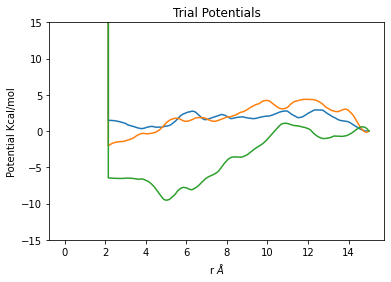

In [6]:
xo = np.linspace(0,15,300)

for i in range(3):
    plt.plot(xo, potentials[random.randint(0,len(potentials))])

plt.ylim(-15, 15)

plt.xlabel('r $\AA$')
plt.ylabel('Potential Kcal/mol')

plt.title('Trial Potentials')

#plot showing some example potentials

Writing the potentials to MagiC then to LAMMPS potential files 

In [5]:
def write_potential(filename, k):
    #write potentials is a function which writes a magic potential file
    #the first argument is the filename, output will be <filename>.pot
    #k is the index of potential used
    
    N = len(input_rdf.AtomTypes)
    N_NB = int(N*(N+1)/2) 
    #number of non-bonded interactions
    N_B = int(0) 
    #number of bonded interactions (not currently supported)
    N_A = int(0) 
    #number of angle interactions (not currently supported)

    AtomList = []
    for i in range(len(input_rdf.AtomTypes)):
        AtomList.append(input_rdf.AtomTypes[i])
    #AtomList contains all the different types of atom in the system 
    #in this case Na is the only atom type
        
    AtomPairs = list(it.combinations_with_replacement(AtomList, r = 2)) 
    #all possible atoms pairs, no repeats
    
    general_section = " &General \n" + " NTypes= {} \n".format(N) + " N_NB= {} \n".format(N_NB) + \
    " N_B= {} \n".format(N_B) + " N_A= {} \n".format(N_A)+ " Min= {} \n".format(Min) + " Max= {} \n".format(Max) + \
    " NPoints= {} \n".format(NPoints) + " &EndGeneral \n"
    #the section at the top of the MagiC .pot file
    
    potential_section = ''
    
    for i in range(len(AtomPairs)):
        #for every atom pair combination
        single_pot = potentials[k]
        #single_pot is an array containing the potential to be used for that atom pair
        header_section = " &Potential \n" + " Name= {}-{} \n".format(AtomPairs[i][0], AtomPairs[i][1]) + \
        " Type = NB \n" \
        + " Min= {} \n".format(Min) + " Max= {} \n".format(Max) + " NPoints= {} \n".format(NPoints) + \
        " AtomTypes= {},{} \n".format(AtomPairs[i][0], AtomPairs[i][1])
        #the header section for that atom pair
        
        table_section = ' &Table \n'
        for j in range(len(rvalues)):
            rval = format(rvalues[j], '.7f')
            potval = format(single_pot[j], '.7f')
            table_section = table_section + "     " + str(rval) + "  " + str(potval) + " \n"
            
        #the actual  potential values at given distances for that atom pair
            
        table_section = table_section + " &EndTable \n" + " &EndPotential \n"
        #the footer for the atom pair
        
        potential_section = potential_section + header_section + table_section
        #adding the new potential section for the i th pair to the overall potential section
        
    potfile = open('{}.pot'.format(filename), 'w')
    #create the new file filename.pot
    potfile.write(general_section)
    #write the header section
    potfile.write(potential_section)
    #write all the potentials to the file
    potfile.close()
    #saving the file to filename.pot
    
    
#see Other_Jupyter_Notebooks/Creating_Potentials for a modified function which can deal with more than 1 bead type

Writing LAMMPS potential files

In [ ]:
for i in range(10000):
    write_potential('Magic_Potentials/potential{}'.format(i), i)
    pot = mt.ReadPot('MagiC_Potentials/potential{}.pot'.format(i), quiet = True)
    mt.PotsExport(pot, MDEngine = 'LAMMPS', Rmaxtable = 15.5, PHImaxtable = 180.0, \
                    npoints = 2500, Umax = 6000.0, \
                    interpol = True, method = 'gauss', sigma = 0.5, noplot=True, hardcopy = False, \
                    filename = 'LAMMPS_Potentials/potential{}'.format(i))
    
#loop which first writes the potential to MagiC potential files, then uses MagicTools PotsExport to write LAMMPS
#potential files

Writing LAMMPS input files

In [9]:
inp = open("Setup/NaNa.in", "r")
#Setup/NaNa.in is the LAMMPS input file used to run the initial simulation
inp_lines = inp.readlines() 
#indexed list where each element is a string containing a single line from the LAMMPS input file
inp.close
for i in range(len(inp_lines)):
    print('{}: '.format(i) + inp_lines[i])
#prints the input file line by line, with each line preceded by its index


#in general, the input file should be a LAMMPS input file for the Coarse Grained system
#with all information except the potentials

0: processors 1 1 1

1: units real

2: atom_style atomic

3: 

4: region box block 0 40 0 40 0 40

5: create_box 1 box

6: create_atoms 1 random 20 2352 box

7: mass 1 23

8: 

9: pair_style table linear 1000

10: pair_coeff 1 1 target_potential.Na_Na.table Na_Na

11: 

12: velocity all create 0.5 157

13: 

14: neighbor 0.5 bin

15: neigh_modify every 20 delay 0 check no 

16: 

17: fix 1 all nvt temp 300 300 100

18: dump id all xtc 100 NaNa.xtc

19: 

20: timestep 1

21: 

22: run 1000000


In [ ]:
def write_input_xtc(i):
    #function to write the LAMMPS input files to generate the training data
    #i is the index of the file to be written
    #the potential file to be read is LAMMPS_Potentials/potential{i}.Na_Na.table
    inp = open("Setup/NaNa.in", "r")
    inp_lines = inp.readlines()
    inp.close
    #read in the base input
    
    inp_lines[10] = 'pair_coeff 1 1 LAMMPS_Potentials/potential{}.Na_Na.table Na_Na'.format(i)
    #changes the potential to be sued
    
    inp_lines[18] = 'dump id all xtc 100 LAMMPS_Trajectories/traj{}.xtc'.format(i)
    #change the output file to be LAMMPS_Trajectories/traj{i}.xtc
    
    inp_lines[22] = 'run 300000'
    #shorten the simulation time from 10ns to 3ns (may be possible to go shorter, which would improve both simulation
    #time and time taken to create the RDFs)
    
    out = open('LAMMPS_Inputs/input{}.in'.format(i), 'w')
    for obj in inp_lines:
        out.write(obj)
    out.close
    #write the new input file to LAMMPS_Inputs/input{i}.in
    
    
#see Other_Jupyter_Notebooks/Creating_Potentials for a modified function which can deal with more than 1 bead type

In [ ]:
for i in range(10000):
    write_input_xtc(i)
    os.system('lmp -in LAMMPS_Inputs/input{i}.in')
#loop to write the 10,000 input files
#LAMMPS MISC library is needed to write .xtc files
#then run the LAMMPS simulations (for larger systems mpirun will likely be necessary)

## Creating the RDFs

In [11]:
inp = open("Setup/NaNa.inp", "r")
#Setup/NaNa.inp is the input script used to create the RDF from the initial simulation


inp_lines = inp.readlines()
inp.close
for i in range(len(inp_lines)):
    print('{}: '.format(i) + inp_lines[i])
    
#reading and printing the base rdf.py input script

0: &Parameters

1:  TrajFile = NaNa.xtc

2:  NMType = 1

3:  NameMType = Na+.CG,

4:  NMolMType = 20,

5:  NFBEG = 1,

6:  NFEND = 1,

7:  ISTEP = 1, 

8:  OutputFile = NaNa.rdf

9:  RMaxNB = 15.

10:  RMaxB =10.0

11:  ResolNB =0.05

12:  ResolB=0.02

13:  ResolA=1.0

14: &ENDParameters

15: 

16: &CGTypes

17: Na: Na

18: &EndCGTypes

19: 

20: &RDFsNB

21: Add: all

22: &EndRDFsNB

23: 

24: &RDFsB

25: &EndRDFsB

26: 

27: &RDFsA

28: &EndRDFsA



In [12]:
def write_rdf_inp(i):
    #function which writes rdf creation input script for traj{i}.xtc, resulting in rdf{i}.rdf
    inp = open("Setup/NaNa.inp", "r")
    inp_lines = inp.readlines()
    inp.close

    inp_lines[1] = ' TrajFile = LAMMPS_Trajectories/traj{}.xtc \n'.format(i)
    #changing the input trajectory filename
    
    inp_lines[8] = ' OutputFile = RDFs/rdf{}.rdf \n'.format(i)
    #changing the output rdf filename
    
    out = open('RDF_Inputs/rdfinput{}.inp'.format(i), 'w')
    for obj in inp_lines:
        out.write(obj)
    out.close
    #writing and saving the rdf input file
    
#see Other_Jupyter_Notebooks/Creating_RDFs for a modified function which can deal with more than 1 bead type

.mmol topography files are needed to run rdf.py

Other_Jupyter_Notebooks/Creating_RDFs also has function to create necessary .mmol files

In [ ]:
for i in range(10000):
    write_rdf_inp(i)
    os.system('rdf.py -i RDF_Inputs/rdfinput{}.inp'.format(i))
    
#writing RDF input files and then running rdf.py
#rdf.py is part of MagiC-3

## Creating DNN training data

In [6]:
rdflist = []
potlist = []
for i in range(10000):
    rdfval = mt.ReadRDF('RDFs/rdf{}.rdf'.format(i), quiet = True)
    rdflist.append(rdfval)
    potval = mt.ReadPot('Magic_Potentials/potential{}.pot'.format(i), quiet = True)
    potlist.append(potval)
    
#rdflist and potlist contain lists where each list element is a DFset object (see MagiCTools documentation)

In [7]:
x = rvalues
# x is the array of rvalues, or the distances at which the indivual points in the RDFs and potentials are defined

In [8]:
print(len(rdflist))
print(len(potlist))

10000
10000


In [9]:
rdfs = []
for i in range(len(rdflist)):
    N = len(rdflist[i].DFs)
    #N is the number of pair interactions, in this example N = 1
    #Since RDFset objects exclude the forbidden region by default, it is necessary to first create an array holding
    #the entire RDF, then cut out the necessary parts
    #this is because it is not necessary that all teh RDFset objects have the same start and endpoints
    
    for j in range(N):
        holder = np.empty((300))
        #empty array to hold the entire rdf
        startindex = np.where(x == round(rdflist[i].DFs[j].x[0], 3))[0][0]
        #startindex is the rvalues index corresponding to the first non-zero RDF value, 
        #i.e. the index for the smallest rvalue outside the forbidden region 
        for k in range(300):
            if k < startindex:
                holder[k] = 0 
                #if k < startindex, x[k] is within forbidden region, so RDF value is 0
            elif k >= startindex and k-startindex < len(rdflist[i].DFs[j].x):
                holder[k] = rdflist[i].DFs[j].y[k-startindex]
                #if the element is within the DFset object take the RDF value from the object
            else:
                holder[k] = 0
                #if the DFset object ends early set the RDF value to zero
                #the object can end early if teh RDF is 0 valued above a certain r value
        
        new = np.zeros(len(input_rdf.DFs[0].x))
        #array for the RDF exluding the forbidden region
        #len(input_rdf.DFs[0].x) is the length of the non-forbidden region from the initial (input) RDF
        for l in range(1, len(new) + 1):
            new[-l] = holder[-l]
        #fills the new array, starting from the end (large r) until it reaches the forbidden region 
        
        new = tf.constant(new)
        #changes array to TensorFlow object
        
        rdfs.append(new)
        #puts the tensorflow object in the list
        
#this loop creates the list rdfs, where each element is a tensorflow object of the rdfs, exluding the forbidden region
#will need some modification to be compatible with systems of different number of bead type
#final tf object may be of shape ~(N, 300) before forbidden region is removed

#may also be beneicial to change to definition of the forbidden region so it includes areas where the RDF has non-zero
#but very small values

In [10]:
pots = []
for i in range(len(potlist)):
    N = len(rdflist[i].DFs)
    
    for j in range(N):
        holder = np.empty((300))
        
        startindex = np.where(x == round(potlist[i].DFs[j].x[0], 3))[0][0]
        for k in range(300):
            if k < startindex:
                holder[k] = 50000 - 100*i 
                #inside forbidden region large potential with negative linear slope
            elif k >= startindex and k-startindex < len(potlist[i].DFs[j].x):
                holder[k] = potlist[i].DFs[j].y[k-startindex] + 30
            else:
                print("error", i, j)
        
        new = np.zeros(len(potlist[0].DFs[0].x))
        for l in range(1, len(new) + 1):
            new[-l] = holder[-l]
        
        new = tf.constant(new)
        pots.append(new)
        
#same format as creating rdfs
#but potential in the forbidden region is very large with negative linear slope
#and potentials cannot end early, unlike RDFs

#potentials are also shifted up by 30 to improve the performance of the network
#if the network target data has many values around zero the networks performance can be reduced

In [11]:
print(len(pots))
print(len(rdfs))

10000
10000


In [12]:
inputs = tf.stack(rdfs)
outputs = tf.stack(pots)
#changing the lists into tensorflow compatible inputs and output tensors

## Building the network

In [13]:
opt = tf.keras.optimizers.Adam()
#the optimzer used to train the network

In [14]:
model = Sequential()

model.add(Dense(rdfs[0].shape[0], activation = 'selu', input_shape = rdfs[0].shape))
model.add(Dense(80, activation = 'selu'))
model.add(Dense(80, activation = 'selu'))

model.add(Dense(pots[0].shape[0]))

model.summary()

#building the dnn
#for more complex system, the input shape will look something like (N, 257)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 257)               66306     
_________________________________________________________________
dense_1 (Dense)              (None, 80)                20640     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_3 (Dense)              (None, 257)               20817     
Total params: 114,243
Trainable params: 114,243
Non-trainable params: 0
_________________________________________________________________


## Training the network

In [52]:
loss_object = tf.keras.losses.MeanSquaredError()

#object to calculate Mean Squared Error

In [15]:
model.compile(loss = tf.keras.losses.MeanSquaredError(), optimizer = opt)
#use MSE for loss is standard for regression
history = model.fit(inputs, outputs, epochs = 2000, batch_size = 100, verbose = 0, validation_split = 0.2)
#training the network

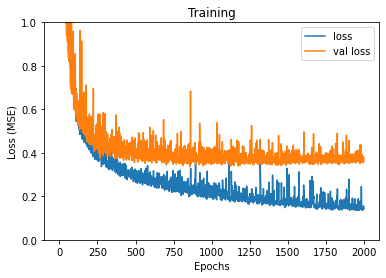

In [16]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.ylim(0, 1)

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training')

plt.savefig('trainingloss.png')

#plotting network performance during training

In [25]:
model.save('modelname')
#saving the newly trained network

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model7/assets


In [36]:
print('loss = ' + str(history.history['loss'][-1]))
print('val_loss = ' + str(history.history['val_loss'][-1]))

#finding the loss and val loss for the trained network

loss = 0.1450379192829132
val_loss = 0.37820079922676086


Model1: loss ~ 1.5 \
        val_loss ~ 0.9
        
        
Model2: loss ~ 0.17 \
        val_loss ~ 0.47
        
        
Model3: loss ~ 0.17 \
        val_loss ~ 0.45
        
        
Model4: loss: 0.1957 \
val_loss: 0.3878

Model5: loss: 0.2075 \
val_loss: 0.3788

Model6: loss: 0.1921 \
 val_loss: 0.3682
 
Model7: loss: .145037 \
val_loss: 0.37820


Despite having worse network performance, Model7 appears to have very slighty better performance on the Test Na+ RDF (than model 6)

## Testing the network

In [37]:
test_inp = np.array(input_rdf.DFs[0].y)

#taking the input read in from the start of the notebook
#from first cell after importing libraries

In [19]:
input_pot = mt.ReadPot('Setup/NaNa.pot', quiet= True)
inpot = np.array(input_pot.DFs[0].y)

#read in the true potential the network is attempting the recreate

In [47]:
test = np.array([test_inp])

modelpred = model.predict([test])
#use the network to make a prediction

z = np.linspace(0, 15, 300)

testpred = np.zeros(300)
act = np.zeros(300)
#array to hold the full predicted and actual potentials 

for i in range(1, 301):
    if i < len(modelpred[0]):
        testpred[-i] = modelpred[0][-i]
    else:
        testpred[-i] = 50000 + 3*i
        
        
    if i < len(inpot):
        act[-i] = inpot[-i]
    else:
        act[-i] = 50000 + 3*i
        
#add in the the forbidden region
#the predicted and input arrays are cut to exclude the forbidden region

testpred = testpred - 30

#shift the predicted potential back down

Text(0.5, 1.0, 'Pots (Trained Model)')

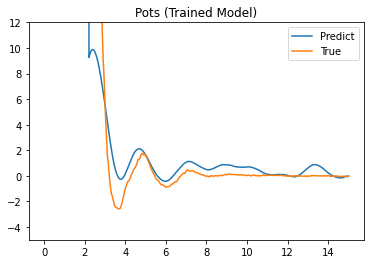

In [55]:
plt.plot(z, testpred, label = 'Predict')
plt.plot(z, act, label = 'True')
    
plt.legend()
plt.ylim(-5,12)
plt.title('Pots (Trained Model)')

#plot of the predicted and actual potentials using the trained network

In [56]:
ytrue = np.zeros(244)
ypred = np.zeros(244)

for i in range(1, 245):
    ytrue[-i] = inpot[-i]
    ypred[-i] = testpred[-i]
    
print(loss_object(ytrue, ypred))

tf.Tensor(0.9843105673789978, shape=(), dtype=float64)


In [27]:
loadmodel = tf.keras.models.load_model('Model7', compile = False)
loadmodel.summary()
loadmodel.compile()

#load and compile one of the previous trained networks

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 257)               66306     
_________________________________________________________________
dense_1 (Dense)              (None, 80)                20640     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_3 (Dense)              (None, 257)               20817     
Total params: 114,243
Trainable params: 114,243
Non-trainable params: 0
_________________________________________________________________


In [45]:
test = np.array([test_inp])

modelpred = loadmodel.predict([test])

z = np.linspace(0, 15, 300)

pred = np.zeros(300)
act = np.zeros(300)

for i in range(1, 301):
    if i < len(modelpred[0]):
        pred[-i] = modelpred[0][-i]
    else:
        pred[-i] = 50000 + 50*i
        
        
    if i < len(inpot):
        act[-i] = inpot[-i]
    else:
        act[-i] = 50000 + 50*i
        
pred = pred - 30
#repeat the process to make a prediction, this time using the loaded trained network

Text(0.5, 1.0, 'Pots (Load Model)')

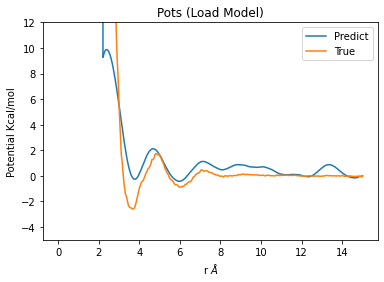

In [49]:
plt.plot(z, pred, label = 'Predict')
plt.plot(z, act, label = 'True')
    
plt.legend()
plt.ylim(-5,12)
plt.xlabel('r $\AA$')
plt.ylabel('Potential Kcal/mol')

plt.title('Pots (Load Model)')

#plot of predicted and actual potentials using loaded network

In [63]:
ytrue = np.zeros(243)
ypred = np.zeros(243)

for i in range(1, 244):
    ytrue[-i] = act[-i]
    ypred[-i] = test[0][-i]
    
print(loss_object(ytrue, ypred))
#find the MSE of the non forbidden region (roughly cut for the larger forbidden region)

tf.Tensor(3.366459846496582, shape=(), dtype=float64)


In [64]:
N = len(input_rdf.AtomTypes)
N_NB = int(N*(N+1)/2) #number of non-bonded interactions
N_B = int(0) #number of bonded interactions
N_A = int(0) #number of angle interactions

AtomList = []
for i in range(len(input_rdf.AtomTypes)):
    AtomList.append(input_rdf.AtomTypes[i])
        
AtomPairs = list(it.combinations_with_replacement(AtomList, r = 2)) #all possible atoms pairs, no repeats
    
general_section = " &General \n" + " NTypes= {} \n".format(N) + " N_NB= {} \n".format(N_NB) + \
" N_B= {} \n".format(N_B) + " N_A= {} \n".format(N_A)+ " Min= {} \n".format(Min) + " Max= {} \n".format(Max) + \
" NPoints= {} \n".format(NPoints) + " &EndGeneral \n"
    
potential_section = ''
for i in range(len(AtomPairs)):
    
    single_pot = pred #this is the potential that will be written
    
    
    header_section = " &Potential \n" + " Name= {}-{} \n".format(AtomPairs[i][0], AtomPairs[i][1]) + \
    " Type = NB \n" \
    + " Min= {} \n".format(Min) + " Max= {} \n".format(Max) + " NPoints= {} \n".format(NPoints) + \
    " AtomTypes= {},{} \n".format(AtomPairs[i][0], AtomPairs[i][1])
        
    table_section = ' &Table \n'
    for j in range(len(rvalues)):
        rval = format(rvalues[j], '.7f')
        potval = format(single_pot[j], '.7f')
        table_section = table_section + "     " + str(rval) + "  " + str(potval) + " \n"
            
    table_section = table_section + " &EndTable \n" + " &EndPotential \n"
        
    potential_section = potential_section + header_section + table_section
        
potfile = open('Test/pred.pot', 'w')
potfile.write(general_section)
potfile.write(potential_section)
potfile.close()

#writing the predicted potential to a file

#modified version of write_potential()

In [65]:
pot = mt.ReadPot('Test/pred.pot', quiet = True)
mt.PotsExport(pot, MDEngine = 'LAMMPS', Rmaxtable = 15.5, PHImaxtable = 180.0, \
                npoints = 2500, Umax = 6000.0, \
                interpol = True, method = 'gauss', sigma = 0.5, noplot=True, hardcopy = False, \
                filename = 'Test/predpotential')

#write the potential to a LAMMPS file

## Comparing RDFs

Simualtion was run using the network predicted potential, and RDF was calcaulted from this simulation.
This RDF was then compared to the RDF from the intial simulation

All the files needed for this simulation are in the Test folder

In [ ]:
os.system('lmp -in pred.in')
os.system('rdf.py -i pred.inp')

#run the simulation then calculate RDF

In [2]:
testrdf = mt.ReadRDF('Test/pred.rdf', quiet = True)
truerdf = mt.ReadRDF('Setup/NaNa.rdf', quiet = True)

#load in the RDF from the initial simulation and the RDF from the simulation using the predicted potential

In [6]:
x = rvalues
for i in range(2):
    
    if i == 0:
        obj = testrdf.DFs[0]
    if i == 1:
        obj = truerdf.DFs[0]
    N = 1
    
    for j in range(N):
        holder = np.empty((300))
        startindex = np.where(x == round(obj.x[0], 3))[0][0]
        for k in range(300):
            if k < startindex:
                holder[k] = 0
            elif k >= startindex and k-startindex < len(obj.x):
                holder[k] = obj.y[k-startindex]
            else:
                holder[k] = 0
        
    if i == 0:
        test = holder
        
    if i == 1:
        true = holder
        
#read in and format the two RDFs, the RDF from the initial simulation
#and the RDF from the simulation with the predicted potentials

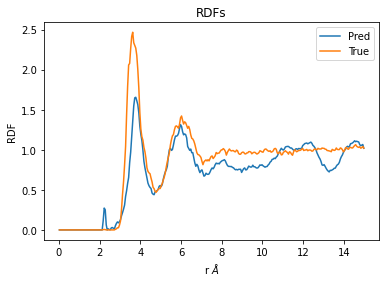

In [7]:
plt.plot(x, test, label = 'Pred')
plt.plot(x, true, label = 'True')

plt.legend()

plt.xlabel('r $\AA$')
plt.ylabel('RDF')
plt.title('RDFs')

plt.savefig('rdfs.png')

#plot the two RDFs